In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"frlfff","key":"3ea8e2ee476c6ad64b25b9632f67a954"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d datasnaek/chess

Dataset URL: https://www.kaggle.com/datasets/datasnaek/chess
License(s): CC0-1.0
  0% 0.00/2.77M [00:00<?, ?B/s]
100% 2.77M/2.77M [00:00<00:00, 38.5MB/s]


In [5]:
! unzip '/content/chess.zip' -d '/content/chess'

Archive:  /content/chess.zip
  inflating: /content/chess/games.csv  


# Пару слов о задаче

__Задача__: обучить модель предсказывать победителя шахматной партии (белые / черные / ничья) по данным из партии.

__Причины выбора датасета__: интересуюсь шахматами; в меру несложный набор данных.

__P.S.__: Блокнот является результатом выполнения лабораторной работы по освоению нейросети FFNN. Т.к. он был сделан в сжатые сроки, я не стал профессионально подходить к анализу данных и преобразовал в датасете только простейшие признаки (а ходы партии я просто исключил из датасета). На мой взгляд, это является следвствием плохого обучения модели - ей недостаточно признаков. В любом случае, в последних частях работы описаны возможные подходы к решению плохой обучаемости.

# Анализ и обработка датасета

In [6]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Загрузка датасета

In [73]:
df = pd.read_csv("/content/chess/games.csv")
print(df.shape)
df.head(5)

(20058, 16)


,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,False,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,True,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


## Преобразование столбцов

* __Преобразуем столбец `rated` из булевого в числовой вид__

In [75]:
df['rated'] = df['rated'].astype(int)
df.head(3)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,outoftime,white,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,resign,black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3


* __Преобразуем текстовые данные в столбцах `increment_code`, `opening_eco`__

In [76]:
df_additional = {'base_time': [], 'additional_time': []}

for code in df['increment_code']:
    base, add = map(int, code.split('+'))
    df_additional['base_time'].append(base)
    df_additional['additional_time'].append(add)

df_additional = pd.DataFrame(df_additional)
df = pd.concat([df, df_additional], axis=1)
df = df.drop(columns=['increment_code'])
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply,base_time,additional_time
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,outoftime,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,Slav Defense: Exchange Variation,5,15,2
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,resign,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,Nimzowitsch Defense: Kennedy Variation,4,5,10
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,mate,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3,5,10
3,kWKvrqYL,1,1.504110e+12,1.504110e+12,61,mate,white,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3,20,0
4,9tXo1AUZ,1,1.504030e+12,1.504030e+12,95,mate,white,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5,30,3


In [77]:
df_additional = {'opening_eco_letter': [], 'opening_eco_number': []}

for value in df['opening_eco']:
    letter = value[0]
    number = int(value[1:])
    df_additional['opening_eco_letter'].append(letter)
    df_additional['opening_eco_number'].append(number)

df_additional = pd.DataFrame(df_additional)
df = pd.concat([df, df_additional], axis=1)
df = df.drop(columns=['opening_eco'])
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,white_id,white_rating,black_id,black_rating,moves,opening_name,opening_ply,base_time,additional_time,opening_eco_letter,opening_eco_number
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,outoftime,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,Slav Defense: Exchange Variation,5,15,2,D,10
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,resign,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,Nimzowitsch Defense: Kennedy Variation,4,5,10,B,0
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,mate,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,King's Pawn Game: Leonardis Variation,3,5,10,C,20
3,kWKvrqYL,1,1.504110e+12,1.504110e+12,61,mate,white,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,Queen's Pawn Game: Zukertort Variation,3,20,0,D,2
4,9tXo1AUZ,1,1.504030e+12,1.504030e+12,95,mate,white,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,Philidor Defense,5,30,3,C,41


In [78]:
# astype(int) to get 1/0 instead of true/false
dummies = pd.get_dummies(df['opening_eco_letter'], prefix='opening_eco_letter').astype(int)

df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['opening_eco_letter'])
df.head(5)

,id,rated,created_at,last_move_at,turns,victory_status,winner,white_id,white_rating,black_id,...,opening_name,opening_ply,base_time,additional_time,opening_eco_number,opening_eco_letter_A,opening_eco_letter_B,opening_eco_letter_C,opening_eco_letter_D,opening_eco_letter_E
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,outoftime,white,bourgris,1500,a-00,...,Slav Defense: Exchange Variation,5,15,2,10,0,0,0,1,0
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,resign,black,a-00,1322,skinnerua,...,Nimzowitsch Defense: Kennedy Variation,4,5,10,0,0,1,0,0,0
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,mate,white,ischia,1496,a-00,...,King's Pawn Game: Leonardis Variation,3,5,10,20,0,0,1,0,0
3,kWKvrqYL,1,1.504110e+12,1.504110e+12,61,mate,white,daniamurashov,1439,adivanov2009,...,Queen's Pawn Game: Zukertort Variation,3,20,0,2,0,0,0,1,0
4,9tXo1AUZ,1,1.504030e+12,1.504030e+12,95,mate,white,nik221107,1523,adivanov2009,...,Philidor Defense,5,30,3,41,0,0,1,0,0


* __Преобразуем категориальные данные в столбце `victory_status`__

In [79]:
dummies = pd.get_dummies(df['victory_status'], prefix='victory_status').astype(int)
df = pd.concat([df, dummies], axis=1)
df = df.drop(columns=['victory_status'])
df.head(5)

,id,rated,created_at,last_move_at,turns,winner,white_id,white_rating,black_id,black_rating,...,opening_eco_number,opening_eco_letter_A,opening_eco_letter_B,opening_eco_letter_C,opening_eco_letter_D,opening_eco_letter_E,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign
0,TZJHLljE,0,1.504210e+12,1.504210e+12,13,white,bourgris,1500,a-00,1191,...,10,0,0,0,1,0,0,0,1,0
1,l1NXvwaE,1,1.504130e+12,1.504130e+12,16,black,a-00,1322,skinnerua,1261,...,0,0,1,0,0,0,0,0,0,1
2,mIICvQHh,1,1.504130e+12,1.504130e+12,61,white,ischia,1496,a-00,1500,...,20,0,0,1,0,0,0,1,0,0
3,kWKvrqYL,1,1.504110e+12,1.504110e+12,61,white,daniamurashov,1439,adivanov2009,1454,...,2,0,0,0,1,0,0,1,0,0
4,9tXo1AUZ,1,1.504030e+12,1.504030e+12,95,white,nik221107,1523,adivanov2009,1469,...,41,0,0,1,0,0,0,1,0,0


* __И, наконец, преобразуем столбцы `created_at` и `last_move_at` в столбец `game_duration`__

In [80]:
from datetime import datetime, timezone

In [81]:
# посмтрим на примеры значений столбцов created_at, last_move_at и их разницу
for i in range(15):
    start_time = datetime.fromtimestamp(df['created_at'][i] / 1000, tz=timezone.utc)
    end_time = datetime.fromtimestamp(df['last_move_at'][i] / 1000, tz=timezone.utc)
    difference = end_time.timestamp() - start_time.timestamp()
    print(f"{start_time} | {end_time} | {difference}")

2017-08-31 20:06:40+00:00 | 2017-08-31 20:06:40+00:00 | 0.0
2017-08-30 21:53:20+00:00 | 2017-08-30 21:53:20+00:00 | 0.0
2017-08-30 21:53:20+00:00 | 2017-08-30 21:53:20+00:00 | 0.0
2017-08-30 16:20:00+00:00 | 2017-08-30 16:20:00+00:00 | 0.0
2017-08-29 18:06:40+00:00 | 2017-08-29 18:06:40+00:00 | 0.0
2017-09-01 04:26:40+00:00 | 2017-09-01 04:26:40+00:00 | 0.0
2017-09-01 01:40:00+00:00 | 2017-09-01 01:40:00+00:00 | 0.0
2017-08-25 16:53:20+00:00 | 2017-08-25 16:53:20+00:00 | 0.0
2017-08-23 17:40:00+00:00 | 2017-08-23 17:40:00+00:00 | 0.0
2017-08-22 22:13:20+00:00 | 2017-08-22 22:13:20+00:00 | 0.0
2017-08-21 21:13:20+00:00 | 2017-08-21 21:13:20+00:00 | 0.0
2017-08-21 21:13:20+00:00 | 2017-08-21 21:13:20+00:00 | 0.0
2017-08-21 21:13:20+00:00 | 2017-08-21 21:13:20+00:00 | 0.0
2017-08-21 18:26:40+00:00 | 2017-08-21 18:26:40+00:00 | 0.0
2017-08-30 10:46:40+00:00 | 2017-08-30 13:33:20+00:00 | 10000.0


In [82]:
df['game_duration'] = df.apply(lambda row: (
    datetime.fromtimestamp(row['last_move_at'] / 1000, tz=timezone.utc) -
    datetime.fromtimestamp(row['created_at'] / 1000, tz=timezone.utc)
).total_seconds(), axis=1)

df = df.drop(columns=['created_at', 'last_move_at'])
df.head(5)

,id,rated,turns,winner,white_id,white_rating,black_id,black_rating,moves,opening_name,...,opening_eco_letter_A,opening_eco_letter_B,opening_eco_letter_C,opening_eco_letter_D,opening_eco_letter_E,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,game_duration
0,TZJHLljE,0,13,white,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,Slav Defense: Exchange Variation,...,0,0,0,1,0,0,0,1,0,0.0
1,l1NXvwaE,1,16,black,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,Nimzowitsch Defense: Kennedy Variation,...,0,1,0,0,0,0,0,0,1,0.0
2,mIICvQHh,1,61,white,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,King's Pawn Game: Leonardis Variation,...,0,0,1,0,0,0,1,0,0,0.0
3,kWKvrqYL,1,61,white,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,Queen's Pawn Game: Zukertort Variation,...,0,0,0,1,0,0,1,0,0,0.0
4,9tXo1AUZ,1,95,white,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,Philidor Defense,...,0,0,1,0,0,0,1,0,0,0.0


Видно, что длительность игры часто оказывается нулевая (такие игры я буду считать выбросами), чтобы модель анализировала только игры с положительной длительностью. Исключенные элементы выборки никак не будут аппроксимированы (к примеру, средней длительностью игры), потому что, на мой взгляд, это может разрушить имеющиеся связи между признаками, из-за чего модель может плохо работать на тестовых данных.

Посмотрим, сколько вообще есть игр с ненулевой длительностью

In [83]:
times = set()
k = 0
for duration in df['game_duration']:
    if duration != 0:
        k += 1
        times.add(duration)

print(k)
print(f"{k / df.shape[0] * 100}%")

11510
57.38358759597168%


Игр, не являющихся выбросами, оказалось немного больше половины. Оценим длительность таких игр

<Axes: ylabel='Count'>

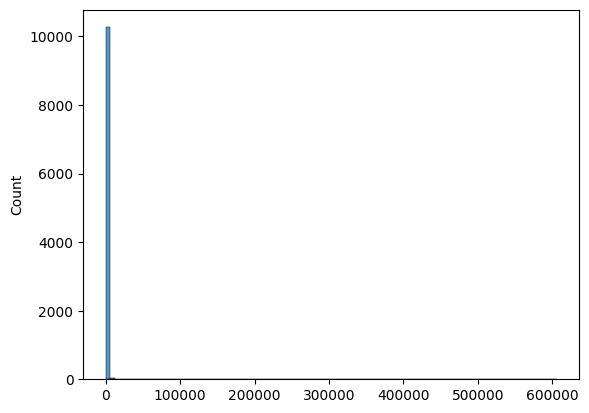

In [84]:
times_arr = sorted(list(times))

sns.histplot(data=times_arr, bins=100)

Присутствуют игры с очень большой длительностью, из-за чего на графике ничего не рассмотреть. Сузим график

<Axes: ylabel='Count'>

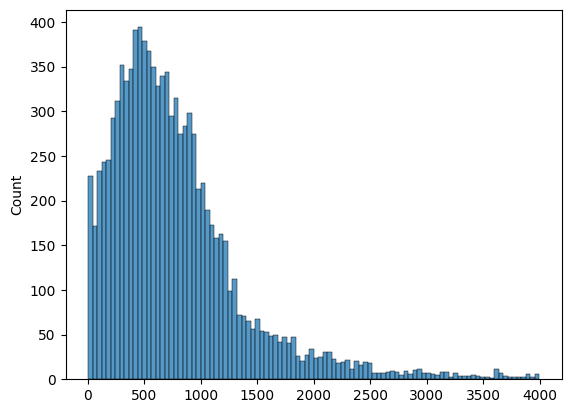

In [85]:
sns.histplot(data=[time for time in times_arr if time < 4000], bins=100)

In [86]:
times_arr[:10]

[1.922, 2.538, 2.723, 2.931, 3.176, 3.428, 3.432, 3.483, 3.508, 3.591]

Видно, что присутствуют игры, которые длились считанные секунды. Это конечно странно, но т.к. таких игр много - я их оставлю.

Посмотрим, какие ходы соответствуют таким играм, чтобы убедиться, что это не выбросы (ходов должно быть мало)

In [87]:
for duration, move in zip(df['game_duration'], df['moves']):
    if duration in times_arr[:10]:
        print(f"Duration: {duration}; Moves: {move}")

Duration: 3.428; Moves: e3 e6
Duration: 3.591; Moves: e4 d5
Duration: 2.723; Moves: e4 d5
Duration: 3.483; Moves: e4 e5
Duration: 3.508; Moves: d3 d6
Duration: 3.432; Moves: e4
Duration: 1.922; Moves: d3
Duration: 2.931; Moves: e4
Duration: 3.176; Moves: e4 e5
Duration: 2.538; Moves: h3 b6


Что ж, видимо, такие короткие игры все же не являются выбросами и я буду использовать их для обучения.

Урежем из датасета игры, которые длились 0 секунд.

In [88]:
df = df[df['game_duration'] > 0]

print(df.shape)
df.head(5)

(11510, 24)


,id,rated,turns,winner,white_id,white_rating,black_id,black_rating,moves,opening_name,...,opening_eco_letter_A,opening_eco_letter_B,opening_eco_letter_C,opening_eco_letter_D,opening_eco_letter_E,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,game_duration
14,u7i6dOaJ,0,31,white,shivangithegenius,1094,sureka_akshat,1141,e4 e5 Nf3 Nc6 Bc4 Nf6 Nc3 Bc5 O-O O-O d3 Ne8 B...,Four Knights Game: Italian Variation,...,0,0,1,0,0,0,1,0,0,10000.0
43,oqoT4DLS,0,66,white,rajuppi,2443,shivangithegenius,978,e4 c5 Nf3 d6 d4 cxd4 Nxd4 Nf6 Nc3 g6 Be3 Bg7 f...,Sicilian Defense: Dragon Variation | Yugoslav...,...,0,1,0,0,0,0,0,0,1,10000.0
49,iq3Kz06t,0,41,white,rajuppi,2436,shivangithegenius,978,e4 d5 exd5 Qxd5 Qf3 Qe5+ Ne2 Nf6 d4 Qd5 Qxd5 N...,Scandinavian Defense: Mieses-Kotroc Variation,...,0,1,0,0,0,0,1,0,0,10000.0
52,KYPdQv8e,0,53,white,shivangithegenius,978,lucasimeon,1500,d4 f5 e3 Nf6 Nc3 d5 Bb5+ c6 Bd3 b5 Qf3 Qa5 Bxf...,Dutch Defense,...,1,0,0,0,0,0,1,0,0,10000.0
54,PBS4FEld,1,8,white,wing175,1521,gerfsh,1162,Nf3 e5 Nxe5 Ke7 e4 Kd6 d4 Nc6,Zukertort Opening: Ross Gambit,...,1,0,0,0,0,0,0,0,1,10000.0


## Удаление лишних столбцов:

In [89]:
# moves - будет сложно анализировать
# opening_name - нет смысла хранить, он напрямую связан со столбцом opening_eco
df = df.drop(columns=['id', 'white_id', 'black_id', 'moves', 'opening_name'])
df.head(5)

,rated,turns,winner,white_rating,black_rating,opening_ply,base_time,additional_time,opening_eco_number,opening_eco_letter_A,opening_eco_letter_B,opening_eco_letter_C,opening_eco_letter_D,opening_eco_letter_E,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,game_duration
14,0,31,white,1094,1141,8,15,15,50,0,0,1,0,0,0,1,0,0,10000.0
43,0,66,white,2443,978,17,40,40,76,0,1,0,0,0,0,0,0,1,10000.0
49,0,41,white,2436,978,4,40,40,1,0,1,0,0,0,0,1,0,0,10000.0
52,0,53,white,978,1500,2,10,0,80,1,0,0,0,0,0,1,0,0,10000.0
54,1,8,white,1521,1162,2,16,0,4,1,0,0,0,0,0,0,0,1,10000.0


In [90]:
df.shape

(11510, 19)

## Отделение целевой функции от датасета. Проверка баланса классов

Отделим target от датасета

In [91]:
target = df['winner']
df = df.drop(['winner'], axis=1)
df.head(1)

,rated,turns,white_rating,black_rating,opening_ply,base_time,additional_time,opening_eco_number,opening_eco_letter_A,opening_eco_letter_B,opening_eco_letter_C,opening_eco_letter_D,opening_eco_letter_E,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,game_duration
14,0,31,1094,1141,8,15,15,50,0,0,1,0,0,0,1,0,0,10000.0


In [92]:
target.unique()

array(['white', 'black', 'draw'], dtype=object)

In [93]:
codes = {'white': 0, 'black': 1, 'draw': 2}
target = target.map(codes)
target.value_counts()

,count
winner,
0,5753
1,5169
2,588


Видно, что присутствует дисбалнас классов. Решать эту проблему будем путем взвешивания классов в дальншем при создании архитектуры модели

## Проверка распределений

In [94]:
numerical_cols = ['turns', 'white_rating', 'black_rating', 'opening_ply',
                  'base_time', 'additional_time', 'opening_eco_number',
                  'game_duration']

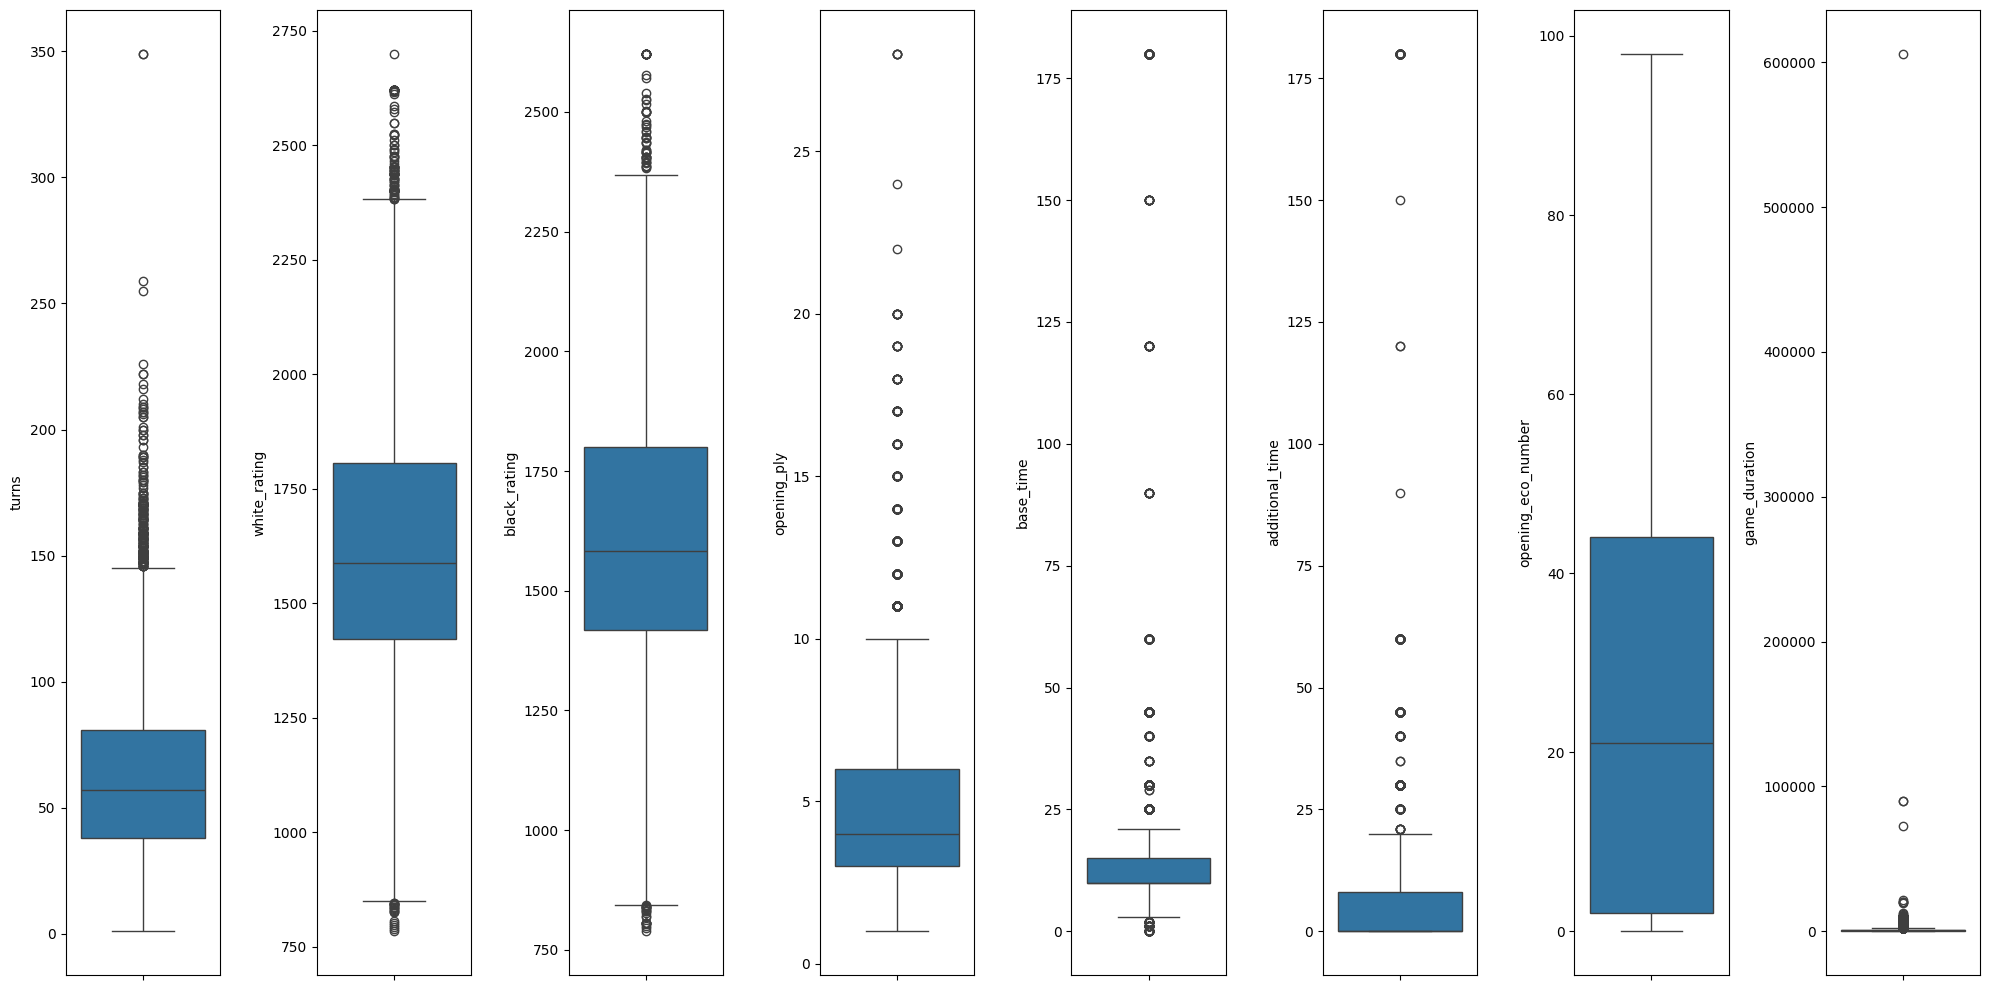

In [95]:
fig=plt.figure(figsize=(20,10))

for i, name in enumerate(numerical_cols):
    ax = fig.add_subplot(1, len(numerical_cols), i+1)
    sns.boxplot(y=df[name], ax=ax)

fig.tight_layout()

Видно, что присутствуют выбросы

## Нормировка данных

In [96]:
from sklearn.preprocessing import RobustScaler

In [97]:
rs = RobustScaler()
df[numerical_cols] = rs.fit_transform(df[numerical_cols])
df.head(5)

,rated,turns,white_rating,black_rating,opening_ply,base_time,additional_time,opening_eco_number,opening_eco_letter_A,opening_eco_letter_B,opening_eco_letter_C,opening_eco_letter_D,opening_eco_letter_E,victory_status_draw,victory_status_mate,victory_status_outoftime,victory_status_resign,game_duration
14,0,-0.604651,-1.289062,-1.156658,1.333333,1.0,1.875,0.690476,0,0,1,0,0,0,1,0,0,12.543114
43,0,0.209302,2.223958,-1.582245,4.333333,6.0,5.000,1.309524,0,1,0,0,0,0,0,0,1,12.543114
49,0,-0.372093,2.205729,-1.582245,0.000000,6.0,5.000,-0.476190,0,1,0,0,0,0,1,0,0,12.543114
52,0,-0.093023,-1.591146,-0.219321,-0.666667,0.0,0.000,1.404762,1,0,0,0,0,0,1,0,0,12.543114
54,1,-1.139535,-0.177083,-1.101828,-0.666667,1.2,0.000,-0.404762,1,0,0,0,0,0,0,0,1,12.543114


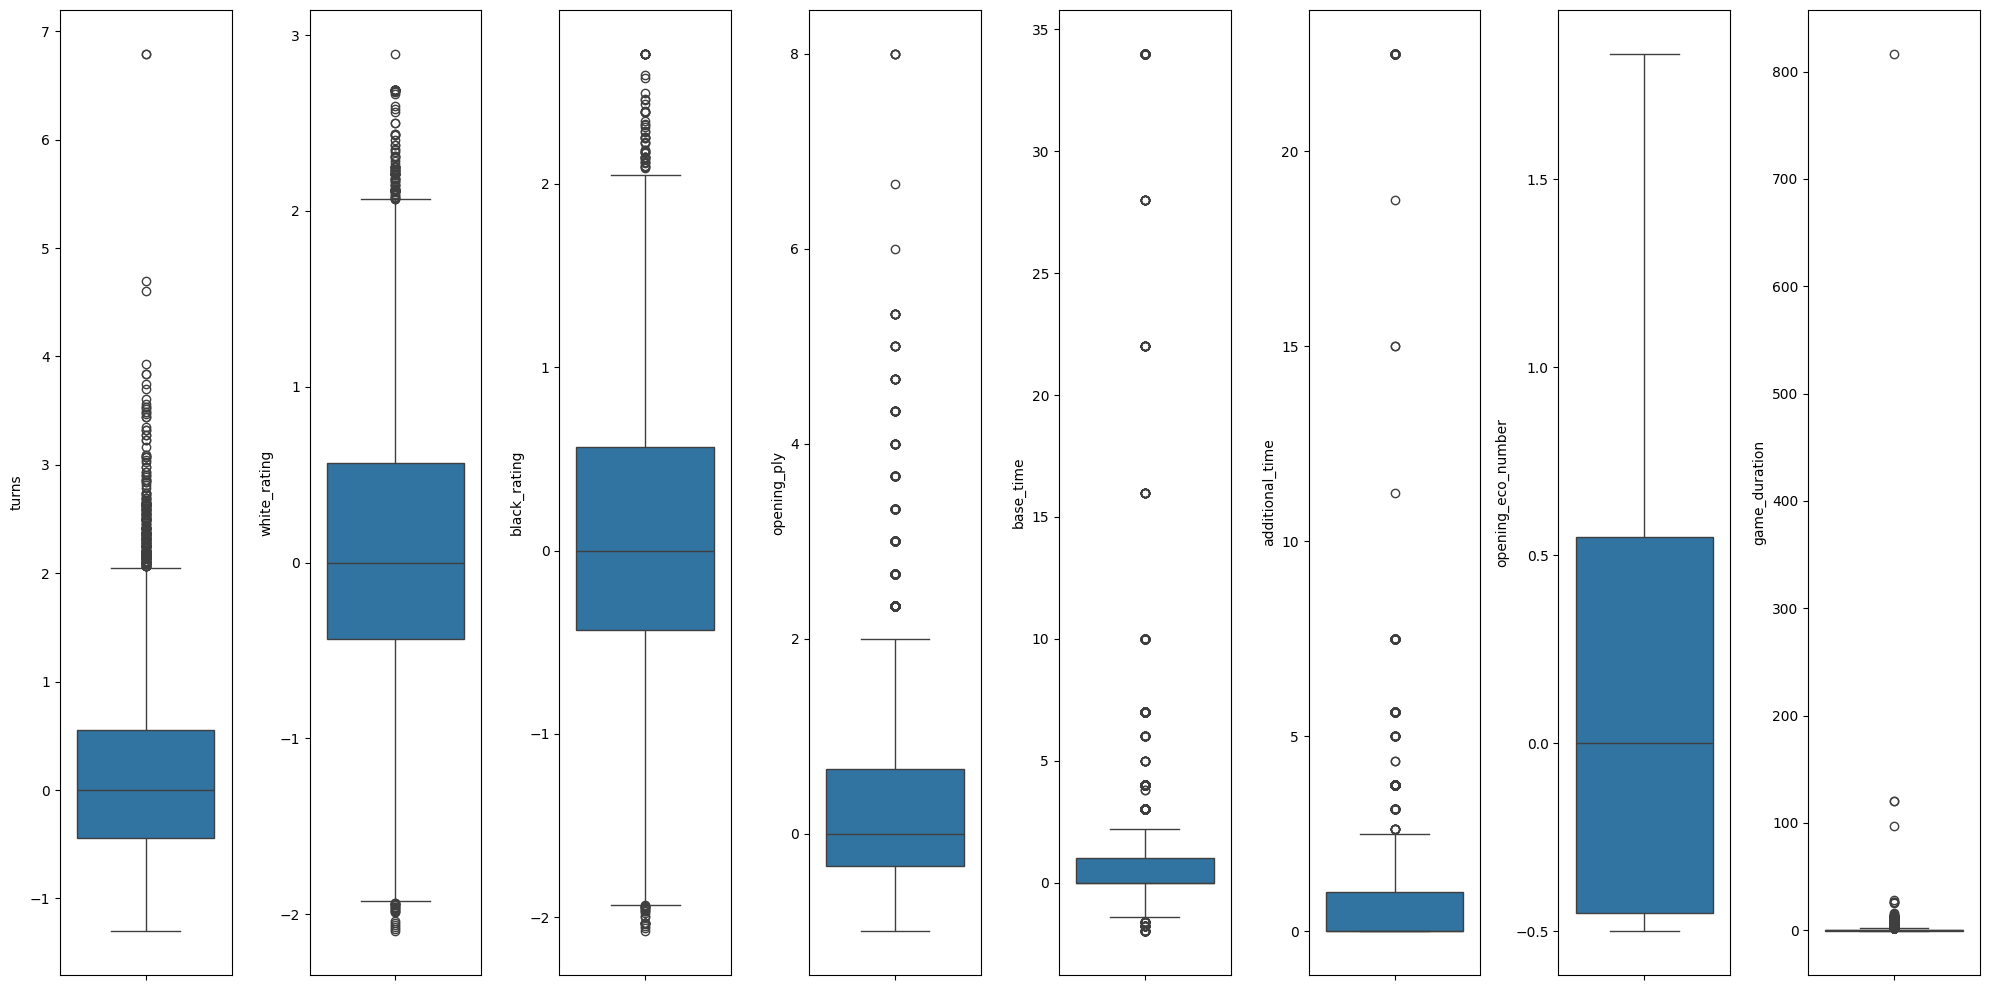

In [98]:
fig=plt.figure(figsize=(20,10))

for i, name in enumerate(numerical_cols):
    ax = fig.add_subplot(1, len(numerical_cols), i+1)
    sns.boxplot(y=df[name], ax=ax)

fig.tight_layout()

## Проврека корреляций

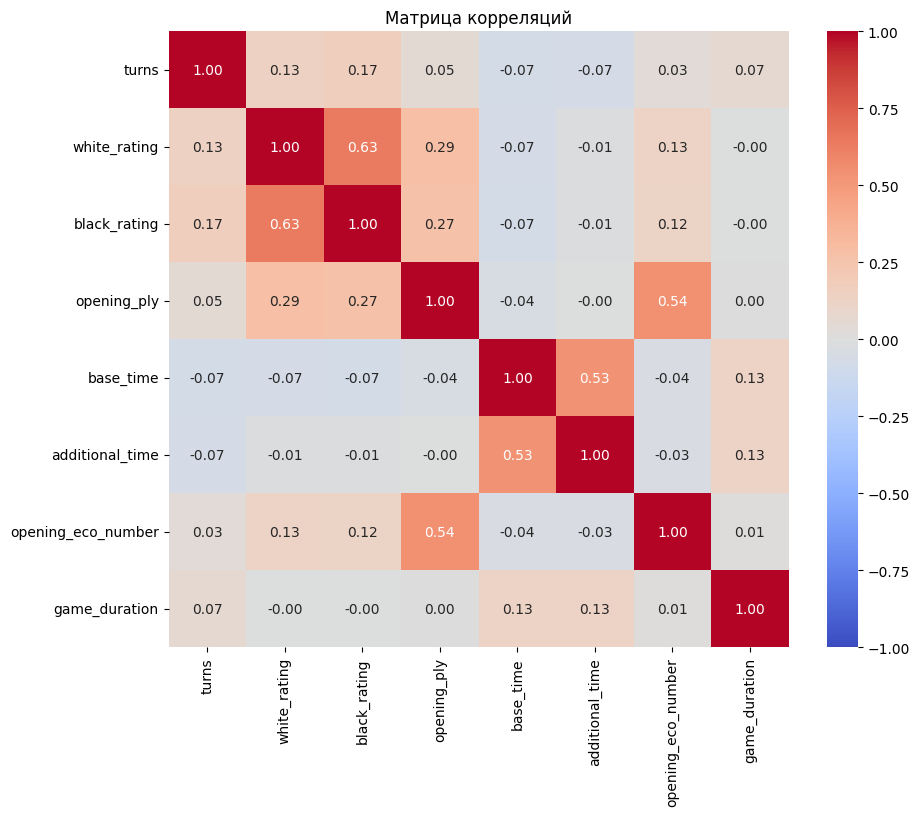

In [99]:
corr_matrix = df[numerical_cols].corr()

# Визуализация тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляций')
plt.show()

Сильных корреляций не обнаружено. Разве что коррлеляция выше 0.5 достигается у тех столбцов, у которых это ожидаемо (например, ELO у черных и белых, как правило, должны быть близки), либо у которых недостаточно много уникальных значений (opening_eco_number)

# Разработка архитектуры модели (FFNN)

In [283]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T

In [105]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Разделение на тренировочную, тестовую и валидационную выборки

In [101]:
from sklearn.model_selection import train_test_split

In [102]:
X = df.values
y = target.values

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test , test_size=0.5, random_state=42)

## Создание датасетов

In [106]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      self.data = torch.Tensor(data)
      self.targets = torch.LongTensor(targets)
      self.transform = transform

  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

  def get_labels(self):
    return self.targets

  def __len__(self):
      return len(self.data)

In [107]:
train_dataset = MyDataset(X_train, y_train)
val_dataset = MyDataset(X_val, y_val)
test_dataset = MyDataset(X_test, y_test)

In [108]:
print(f'''Длина тестовой выборки: {len(test_dataset)}
Длина валидационной выборки: {len(val_dataset)}
Длина тренировочной выборки: {len(train_dataset)}''')

Длина тестовой выборки: 1151
Длина валидационной выборки: 1151
Длина тренировочной выборки: 9208


In [109]:
train_dataset[0]

(tensor([ 1.0000, -0.0930, -0.4766, -0.9399,  1.6667,  0.0000,  0.0000, -0.1429,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  0.3533]),
 tensor(0))

## Создание загрузчиков данных. Определение размера пакета

In [425]:
batch_size = 512 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Архитектура нейросети.

In [426]:
num_features = df.shape[1]
num_labels = len(target.unique())

print(f"Количество экземпляров: {df.shape[0]}")
print(f"Количество признаков: {num_features}")
print(f"Количество меток: {num_labels}")

Количество экземпляров: 11510
Количество признаков: 18
Количество меток: 3


In [427]:
class Classification_Model_FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 256)
        #self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 64)
        #self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        #self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 16)
        #self.bn4 = nn.BatchNorm1d(16)
        self.fc5 = nn.Linear(16, num_labels)
        self.activation = nn.LeakyReLU(inplace=True)
        #self.dropout = nn.Dropout(0.5)

    def forward(self, x): # прямой проход модели
        x = self.fc1(x)
        #x = self.bn1(x)
        x = self.activation(x)
        x = self.fc2(x)
        #x = self.bn2(x)
        x = self.activation(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        x = self.activation(x)
        x = self.fc4(x)
        #x = self.bn4(x)
        x = self.activation(x)
        x = self.fc5(x)
        return x

In [428]:
model = Classification_Model_FFNN()
model.to(device)

Classification_Model_FFNN(
  (fc1): Linear(in_features=18, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [62]:
! pip install torchinfo

from torchinfo import summary

In [429]:
summary(model)

Layer (type:depth-idx)                   Param #
Classification_Model_FFNN                --
├─Linear: 1-1                            4,864
├─Linear: 1-2                            16,448
├─Linear: 1-3                            2,080
├─Linear: 1-4                            528
├─Linear: 1-5                            51
├─LeakyReLU: 1-6                         --
Total params: 23,971
Trainable params: 23,971
Non-trainable params: 0

## Установка фукнции потерь и оптимизатора. Взвешивание классов.

In [221]:
target.value_counts()

,count
winner,
0,5753
1,5169
2,588


In [430]:
class_counts = torch.tensor([5753, 5169, 588])
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights

tensor([0.0841, 0.0936, 0.8224])

In [409]:
#class_weights[0] += 0.05
#class_weights[1] += 0.05
#class_weights[2] -= 0.1
#class_weights

tensor([0.1341, 0.1436, 0.7224])

Полученные веса классов передадим в функцию потерь, там они автоматически будут соответствовать классам по индексам. Т.е. вес под индексом 0 в массиве будет соответствовать целевой функции при target=0

In [431]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters())

## Обучение

In [117]:
from tqdm import tqdm

In [432]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [433]:
train_losses=[]
train_accs=[]
def train(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.train() # веса модели можно обновлять
    running_loss= 0.
    running_acc = 0.

    for data in tqdm(train_loader):
        inputs, targets = data[0].to(device),data[1].to(device) # распаковываем пакеты

        #print(torch.min(targets), torch.max(targets))  # Должно быть 0 и num_classes - 1

        optimizer.zero_grad() # обнуляем градиенты
        outputs=model(inputs) # считаем предсказания - прямой проход модели

        loss=criterion(outputs, targets) # ошибка пакета
        loss.backward() # обратное распространение ошибки
        optimizer.step() # итерация алгоритма оптимизации


        running_loss += loss.item()
        running_acc += accuracy(outputs,targets)

    train_loss=running_loss/len(train_loader)
    train_acc=running_acc/len(train_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    print('Средняя ошибка модели на тренировочной выборке: %.4f'%(train_loss)+'   Средняя точность модели на тренировочной выборке: %.4f'%(train_acc))

In [434]:
val_losses=[]
val_accs=[]
def val(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.eval() # веса модели заморожены
    running_loss = 0.
    running_acc = 0.
    with torch.no_grad(): # запрещаем переисывать градиенты
        for data in tqdm(val_loader):
            inputs, targets=data[0].to(device),data[1].to(device)
            outputs=model(inputs)
            loss=criterion(outputs,targets)

            running_loss += loss.item()
            running_acc += accuracy(outputs,targets)

        val_loss=running_loss/len(val_loader)
        val_acc=running_acc/len(val_loader)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print('Средняя ошибка модели на валидационной выборке: %.4f'%(val_loss)+'   Средняя точность модели на валидационной выборке: %.4f'%(val_acc))

In [435]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [436]:
max_epochs= 100
best_acc=0.0
early_stopper = EarlyStopper(patience=5, min_delta=0.5)
for epoch in range(1,max_epochs+1):
    train(model,epoch)
    val(model,epoch)
    if val_accs[-1] > best_acc:
       torch.save(model, 'best-model.pt')
       best_acc = val_accs[-1]
    if early_stopper.early_stop(val_losses[-1]):
      break


Epoch : 1


100%|██████████| 18/18 [00:00<00:00, 92.56it/s]


Средняя ошибка модели на тренировочной выборке: 1.1087   Средняя точность модели на тренировочной выборке: 0.4429

Epoch : 1


100%|██████████| 3/3 [00:00<00:00, 164.60it/s]


Средняя ошибка модели на валидационной выборке: 1.0718   Средняя точность модели на валидационной выборке: 0.4668

Epoch : 2


100%|██████████| 18/18 [00:00<00:00, 62.17it/s]


Средняя ошибка модели на тренировочной выборке: 1.0136   Средняя точность модели на тренировочной выборке: 0.4489

Epoch : 2


100%|██████████| 3/3 [00:00<00:00, 122.75it/s]


Средняя ошибка модели на валидационной выборке: 0.9361   Средняя точность модели на валидационной выборке: 0.5151

Epoch : 3


100%|██████████| 18/18 [00:00<00:00, 48.15it/s]


Средняя ошибка модели на тренировочной выборке: 0.7676   Средняя точность модели на тренировочной выборке: 0.5447

Epoch : 3


100%|██████████| 3/3 [00:00<00:00, 108.77it/s]


Средняя ошибка модели на валидационной выборке: 0.6635   Средняя точность модели на валидационной выборке: 0.5536

Epoch : 4


100%|██████████| 18/18 [00:00<00:00, 69.84it/s]


Средняя ошибка модели на тренировочной выборке: 0.5554   Средняя точность модели на тренировочной выборке: 0.5889

Epoch : 4


100%|██████████| 3/3 [00:00<00:00, 134.71it/s]


Средняя ошибка модели на валидационной выборке: 0.5235   Средняя точность модели на валидационной выборке: 0.5476

Epoch : 5


100%|██████████| 18/18 [00:00<00:00, 66.77it/s]


Средняя ошибка модели на тренировочной выборке: 0.5141   Средняя точность модели на тренировочной выборке: 0.6026

Epoch : 5


100%|██████████| 3/3 [00:00<00:00, 114.61it/s]


Средняя ошибка модели на валидационной выборке: 0.5614   Средняя точность модели на валидационной выборке: 0.5979

Epoch : 6


100%|██████████| 18/18 [00:00<00:00, 68.38it/s]


Средняя ошибка модели на тренировочной выборке: 0.4984   Средняя точность модели на тренировочной выборке: 0.6170

Epoch : 6


100%|██████████| 3/3 [00:00<00:00, 107.46it/s]


Средняя ошибка модели на валидационной выборке: 0.6338   Средняя точность модели на валидационной выборке: 0.5574

Epoch : 7


100%|██████████| 18/18 [00:00<00:00, 69.41it/s]


Средняя ошибка модели на тренировочной выборке: 0.5206   Средняя точность модели на тренировочной выборке: 0.6208

Epoch : 7


100%|██████████| 3/3 [00:00<00:00, 123.47it/s]


Средняя ошибка модели на валидационной выборке: 0.5424   Средняя точность модели на валидационной выборке: 0.6450

Epoch : 8


100%|██████████| 18/18 [00:00<00:00, 62.72it/s]


Средняя ошибка модели на тренировочной выборке: 0.5040   Средняя точность модели на тренировочной выборке: 0.6450

Epoch : 8


100%|██████████| 3/3 [00:00<00:00, 109.57it/s]


Средняя ошибка модели на валидационной выборке: 0.4678   Средняя точность модели на валидационной выборке: 0.6789

Epoch : 9


100%|██████████| 18/18 [00:00<00:00, 67.39it/s]


Средняя ошибка модели на тренировочной выборке: 0.4431   Средняя точность модели на тренировочной выборке: 0.6676

Epoch : 9


100%|██████████| 3/3 [00:00<00:00, 85.09it/s]


Средняя ошибка модели на валидационной выборке: 0.4825   Средняя точность модели на валидационной выборке: 0.6599

Epoch : 10


100%|██████████| 18/18 [00:00<00:00, 54.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.4289   Средняя точность модели на тренировочной выборке: 0.6709

Epoch : 10


100%|██████████| 3/3 [00:00<00:00, 117.51it/s]


Средняя ошибка модели на валидационной выборке: 0.4618   Средняя точность модели на валидационной выборке: 0.6659

Epoch : 11


100%|██████████| 18/18 [00:00<00:00, 67.47it/s]


Средняя ошибка модели на тренировочной выборке: 0.4228   Средняя точность модели на тренировочной выборке: 0.6730

Epoch : 11


100%|██████████| 3/3 [00:00<00:00, 111.17it/s]


Средняя ошибка модели на валидационной выборке: 0.4811   Средняя точность модели на валидационной выборке: 0.6402

Epoch : 12


100%|██████████| 18/18 [00:00<00:00, 60.37it/s]


Средняя ошибка модели на тренировочной выборке: 0.4211   Средняя точность модели на тренировочной выборке: 0.6734

Epoch : 12


100%|██████████| 3/3 [00:00<00:00, 116.73it/s]


Средняя ошибка модели на валидационной выборке: 0.5061   Средняя точность модели на валидационной выборке: 0.6645

Epoch : 13


100%|██████████| 18/18 [00:00<00:00, 61.20it/s]


Средняя ошибка модели на тренировочной выборке: 0.4202   Средняя точность модели на тренировочной выборке: 0.6733

Epoch : 13


100%|██████████| 3/3 [00:00<00:00, 102.06it/s]


Средняя ошибка модели на валидационной выборке: 0.4898   Средняя точность модели на валидационной выборке: 0.6560

Epoch : 14


100%|██████████| 18/18 [00:00<00:00, 69.95it/s]


Средняя ошибка модели на тренировочной выборке: 0.4187   Средняя точность модели на тренировочной выборке: 0.6712

Epoch : 14


100%|██████████| 3/3 [00:00<00:00, 145.79it/s]


Средняя ошибка модели на валидационной выборке: 0.4577   Средняя точность модели на валидационной выборке: 0.6658

Epoch : 15


100%|██████████| 18/18 [00:00<00:00, 96.51it/s] 


Средняя ошибка модели на тренировочной выборке: 0.4176   Средняя точность модели на тренировочной выборке: 0.6720

Epoch : 15


100%|██████████| 3/3 [00:00<00:00, 115.77it/s]


Средняя ошибка модели на валидационной выборке: 0.4960   Средняя точность модели на валидационной выборке: 0.6493

Epoch : 16


100%|██████████| 18/18 [00:00<00:00, 83.98it/s]


Средняя ошибка модели на тренировочной выборке: 0.4168   Средняя точность модели на тренировочной выборке: 0.6726

Epoch : 16


100%|██████████| 3/3 [00:00<00:00, 220.64it/s]


Средняя ошибка модели на валидационной выборке: 0.4725   Средняя точность модели на валидационной выборке: 0.6737

Epoch : 17


100%|██████████| 18/18 [00:00<00:00, 98.04it/s]


Средняя ошибка модели на тренировочной выборке: 0.4161   Средняя точность модели на тренировочной выборке: 0.6743

Epoch : 17


100%|██████████| 3/3 [00:00<00:00, 128.03it/s]


Средняя ошибка модели на валидационной выборке: 0.4707   Средняя точность модели на валидационной выборке: 0.6770

Epoch : 18


100%|██████████| 18/18 [00:00<00:00, 106.99it/s]


Средняя ошибка модели на тренировочной выборке: 0.4154   Средняя точность модели на тренировочной выборке: 0.6751

Epoch : 18


100%|██████████| 3/3 [00:00<00:00, 149.71it/s]


Средняя ошибка модели на валидационной выборке: 0.4665   Средняя точность модели на валидационной выборке: 0.6678

Epoch : 19


100%|██████████| 18/18 [00:00<00:00, 35.29it/s] 


Средняя ошибка модели на тренировочной выборке: 0.4148   Средняя точность модели на тренировочной выборке: 0.6767

Epoch : 19


100%|██████████| 3/3 [00:00<00:00, 165.09it/s]


Средняя ошибка модели на валидационной выборке: 0.4799   Средняя точность модели на валидационной выборке: 0.6448

Epoch : 20


100%|██████████| 18/18 [00:00<00:00, 93.18it/s] 


Средняя ошибка модели на тренировочной выборке: 0.4141   Средняя точность модели на тренировочной выборке: 0.6778

Epoch : 20


100%|██████████| 3/3 [00:00<00:00, 164.35it/s]


Средняя ошибка модели на валидационной выборке: 0.4766   Средняя точность модели на валидационной выборке: 0.6573

Epoch : 21


100%|██████████| 18/18 [00:00<00:00, 101.02it/s]


Средняя ошибка модели на тренировочной выборке: 0.4135   Средняя точность модели на тренировочной выборке: 0.6787

Epoch : 21


100%|██████████| 3/3 [00:00<00:00, 183.14it/s]


Средняя ошибка модели на валидационной выборке: 0.4933   Средняя точность модели на валидационной выборке: 0.6691

Epoch : 22


100%|██████████| 18/18 [00:00<00:00, 101.81it/s]


Средняя ошибка модели на тренировочной выборке: 0.4130   Средняя точность модели на тренировочной выборке: 0.6792

Epoch : 22


100%|██████████| 3/3 [00:00<00:00, 148.57it/s]


Средняя ошибка модели на валидационной выборке: 0.4781   Средняя точность модели на валидационной выборке: 0.6560

Epoch : 23


100%|██████████| 18/18 [00:00<00:00, 80.60it/s]


Средняя ошибка модели на тренировочной выборке: 0.4124   Средняя точность модели на тренировочной выборке: 0.6812

Epoch : 23


100%|██████████| 3/3 [00:00<00:00, 219.44it/s]


Средняя ошибка модели на валидационной выборке: 0.5918   Средняя точность модели на валидационной выборке: 0.6606

Epoch : 24


100%|██████████| 18/18 [00:00<00:00, 102.49it/s]


Средняя ошибка модели на тренировочной выборке: 0.4118   Средняя точность модели на тренировочной выборке: 0.6814

Epoch : 24


100%|██████████| 3/3 [00:00<00:00, 184.03it/s]


Средняя ошибка модели на валидационной выборке: 0.4890   Средняя точность модели на валидационной выборке: 0.6586

Epoch : 25


100%|██████████| 18/18 [00:00<00:00, 96.50it/s]


Средняя ошибка модели на тренировочной выборке: 0.4113   Средняя точность модели на тренировочной выборке: 0.6815

Epoch : 25


100%|██████████| 3/3 [00:00<00:00, 165.77it/s]


Средняя ошибка модели на валидационной выборке: 0.4887   Средняя точность модели на валидационной выборке: 0.6488

Epoch : 26


100%|██████████| 18/18 [00:00<00:00, 111.41it/s]


Средняя ошибка модели на тренировочной выборке: 0.4107   Средняя точность модели на тренировочной выборке: 0.6818

Epoch : 26


100%|██████████| 3/3 [00:00<00:00, 186.99it/s]


Средняя ошибка модели на валидационной выборке: 0.5068   Средняя точность модели на валидационной выборке: 0.6547

Epoch : 27


100%|██████████| 18/18 [00:00<00:00, 94.27it/s] 


Средняя ошибка модели на тренировочной выборке: 0.4101   Средняя точность модели на тренировочной выборке: 0.6824

Epoch : 27


100%|██████████| 3/3 [00:00<00:00, 129.52it/s]


Средняя ошибка модели на валидационной выборке: 0.5218   Средняя точность модели на валидационной выборке: 0.6448

Epoch : 28


100%|██████████| 18/18 [00:00<00:00, 88.88it/s]


Средняя ошибка модели на тренировочной выборке: 0.4096   Средняя точность модели на тренировочной выборке: 0.6826

Epoch : 28


100%|██████████| 3/3 [00:00<00:00, 158.29it/s]


Средняя ошибка модели на валидационной выборке: 0.5177   Средняя точность модели на валидационной выборке: 0.6540

Epoch : 29


100%|██████████| 18/18 [00:00<00:00, 94.82it/s]


Средняя ошибка модели на тренировочной выборке: 0.4091   Средняя точность модели на тренировочной выборке: 0.6829

Epoch : 29


100%|██████████| 3/3 [00:00<00:00, 187.35it/s]


Средняя ошибка модели на валидационной выборке: 0.5463   Средняя точность модели на валидационной выборке: 0.6658

Epoch : 30


100%|██████████| 18/18 [00:00<00:00, 103.07it/s]


Средняя ошибка модели на тренировочной выборке: 0.4086   Средняя точность модели на тренировочной выборке: 0.6829

Epoch : 30


100%|██████████| 3/3 [00:00<00:00, 160.47it/s]


Средняя ошибка модели на валидационной выборке: 0.5258   Средняя точность модели на валидационной выборке: 0.6645

Epoch : 31


100%|██████████| 18/18 [00:00<00:00, 104.09it/s]


Средняя ошибка модели на тренировочной выборке: 0.4081   Средняя точность модели на тренировочной выборке: 0.6839

Epoch : 31


100%|██████████| 3/3 [00:00<00:00, 145.62it/s]


Средняя ошибка модели на валидационной выборке: 0.5056   Средняя точность модели на валидационной выборке: 0.6494

Epoch : 32


100%|██████████| 18/18 [00:00<00:00, 85.37it/s]


Средняя ошибка модели на тренировочной выборке: 0.4075   Средняя точность модели на тренировочной выборке: 0.6840

Epoch : 32


100%|██████████| 3/3 [00:00<00:00, 138.01it/s]


Средняя ошибка модели на валидационной выборке: 0.5058   Средняя точность модели на валидационной выборке: 0.6534

Epoch : 33


100%|██████████| 18/18 [00:00<00:00, 105.08it/s]


Средняя ошибка модели на тренировочной выборке: 0.4071   Средняя точность модели на тренировочной выборке: 0.6846

Epoch : 33


100%|██████████| 3/3 [00:00<00:00, 155.64it/s]


Средняя ошибка модели на валидационной выборке: 0.5463   Средняя точность модели на валидационной выборке: 0.6474

Epoch : 34


100%|██████████| 18/18 [00:00<00:00, 96.28it/s]


Средняя ошибка модели на тренировочной выборке: 0.4065   Средняя точность модели на тренировочной выборке: 0.6850

Epoch : 34


100%|██████████| 3/3 [00:00<00:00, 171.04it/s]


Средняя ошибка модели на валидационной выборке: 0.4858   Средняя точность модели на валидационной выборке: 0.6507

Epoch : 35


100%|██████████| 18/18 [00:00<00:00, 104.82it/s]


Средняя ошибка модели на тренировочной выборке: 0.4060   Средняя точность модели на тренировочной выборке: 0.6853

Epoch : 35


100%|██████████| 3/3 [00:00<00:00, 155.79it/s]


Средняя ошибка модели на валидационной выборке: 0.5083   Средняя точность модели на валидационной выборке: 0.6803

Epoch : 36


100%|██████████| 18/18 [00:00<00:00, 82.77it/s]


Средняя ошибка модели на тренировочной выборке: 0.4055   Средняя точность модели на тренировочной выборке: 0.6863

Epoch : 36


100%|██████████| 3/3 [00:00<00:00, 119.76it/s]


Средняя ошибка модели на валидационной выборке: 0.4981   Средняя точность модели на валидационной выборке: 0.6461

Epoch : 37


100%|██████████| 18/18 [00:00<00:00, 84.66it/s]


Средняя ошибка модели на тренировочной выборке: 0.4050   Средняя точность модели на тренировочной выборке: 0.6865

Epoch : 37


100%|██████████| 3/3 [00:00<00:00, 178.89it/s]


Средняя ошибка модели на валидационной выборке: 0.5092   Средняя точность модели на валидационной выборке: 0.6619

Epoch : 38


100%|██████████| 18/18 [00:00<00:00, 89.25it/s]


Средняя ошибка модели на тренировочной выборке: 0.4044   Средняя точность модели на тренировочной выборке: 0.6870

Epoch : 38


100%|██████████| 3/3 [00:00<00:00, 156.51it/s]


Средняя ошибка модели на валидационной выборке: 0.5204   Средняя точность модели на валидационной выборке: 0.6566

Epoch : 39


100%|██████████| 18/18 [00:00<00:00, 101.84it/s]


Средняя ошибка модели на тренировочной выборке: 0.4038   Средняя точность модели на тренировочной выборке: 0.6874

Epoch : 39


100%|██████████| 3/3 [00:00<00:00, 151.10it/s]


Средняя ошибка модели на валидационной выборке: 0.6720   Средняя точность модели на валидационной выборке: 0.6488

Epoch : 40


100%|██████████| 18/18 [00:00<00:00, 91.32it/s]


Средняя ошибка модели на тренировочной выборке: 0.4034   Средняя точность модели на тренировочной выборке: 0.6881

Epoch : 40


100%|██████████| 3/3 [00:00<00:00, 139.65it/s]


Средняя ошибка модели на валидационной выборке: 0.6264   Средняя точность модели на валидационной выборке: 0.6738

Epoch : 41


100%|██████████| 18/18 [00:00<00:00, 91.51it/s]


Средняя ошибка модели на тренировочной выборке: 0.4029   Средняя точность модели на тренировочной выборке: 0.6872

Epoch : 41


100%|██████████| 3/3 [00:00<00:00, 160.21it/s]


Средняя ошибка модели на валидационной выборке: 0.5037   Средняя точность модели на валидационной выборке: 0.6678

Epoch : 42


100%|██████████| 18/18 [00:00<00:00, 98.33it/s]


Средняя ошибка модели на тренировочной выборке: 0.4024   Средняя точность модели на тренировочной выборке: 0.6883

Epoch : 42


100%|██████████| 3/3 [00:00<00:00, 144.48it/s]


Средняя ошибка модели на валидационной выборке: 0.5294   Средняя точность модели на валидационной выборке: 0.6567

Epoch : 43


100%|██████████| 18/18 [00:00<00:00, 87.46it/s]


Средняя ошибка модели на тренировочной выборке: 0.4019   Средняя точность модели на тренировочной выборке: 0.6886

Epoch : 43


100%|██████████| 3/3 [00:00<00:00, 153.54it/s]


Средняя ошибка модели на валидационной выборке: 0.5079   Средняя точность модели на валидационной выборке: 0.6534

Epoch : 44


100%|██████████| 18/18 [00:00<00:00, 87.99it/s]


Средняя ошибка модели на тренировочной выборке: 0.4013   Средняя точность модели на тренировочной выборке: 0.6893

Epoch : 44


100%|██████████| 3/3 [00:00<00:00, 97.81it/s]


Средняя ошибка модели на валидационной выборке: 0.5221   Средняя точность модели на валидационной выборке: 0.6468

Epoch : 45


100%|██████████| 18/18 [00:00<00:00, 83.00it/s]


Средняя ошибка модели на тренировочной выборке: 0.4008   Средняя точность модели на тренировочной выборке: 0.6897

Epoch : 45


100%|██████████| 3/3 [00:00<00:00, 191.33it/s]


Средняя ошибка модели на валидационной выборке: 0.5573   Средняя точность модели на валидационной выборке: 0.6606

Epoch : 46


100%|██████████| 18/18 [00:00<00:00, 94.96it/s]


Средняя ошибка модели на тренировочной выборке: 0.4003   Средняя точность модели на тренировочной выборке: 0.6903

Epoch : 46


100%|██████████| 3/3 [00:00<00:00, 162.26it/s]


Средняя ошибка модели на валидационной выборке: 0.5051   Средняя точность модели на валидационной выборке: 0.6475

Epoch : 47


100%|██████████| 18/18 [00:00<00:00, 89.99it/s]


Средняя ошибка модели на тренировочной выборке: 0.3998   Средняя точность модели на тренировочной выборке: 0.6905

Epoch : 47


100%|██████████| 3/3 [00:00<00:00, 170.11it/s]


Средняя ошибка модели на валидационной выборке: 0.5038   Средняя точность модели на валидационной выборке: 0.6613

Epoch : 48


100%|██████████| 18/18 [00:00<00:00, 96.90it/s] 


Средняя ошибка модели на тренировочной выборке: 0.3993   Средняя точность модели на тренировочной выборке: 0.6909

Epoch : 48


100%|██████████| 3/3 [00:00<00:00, 102.86it/s]


Средняя ошибка модели на валидационной выборке: 0.5424   Средняя точность модели на валидационной выборке: 0.6751

Epoch : 49


100%|██████████| 18/18 [00:00<00:00, 79.87it/s]


Средняя ошибка модели на тренировочной выборке: 0.3988   Средняя точность модели на тренировочной выборке: 0.6919

Epoch : 49


100%|██████████| 3/3 [00:00<00:00, 186.83it/s]


Средняя ошибка модели на валидационной выборке: 0.5466   Средняя точность модели на валидационной выборке: 0.6489

Epoch : 50


100%|██████████| 18/18 [00:00<00:00, 96.62it/s]


Средняя ошибка модели на тренировочной выборке: 0.3983   Средняя точность модели на тренировочной выборке: 0.6932

Epoch : 50


100%|██████████| 3/3 [00:00<00:00, 130.72it/s]


Средняя ошибка модели на валидационной выборке: 0.6089   Средняя точность модели на валидационной выборке: 0.6370

Epoch : 51


100%|██████████| 18/18 [00:00<00:00, 94.17it/s]


Средняя ошибка модели на тренировочной выборке: 0.3978   Средняя точность модели на тренировочной выборке: 0.6938

Epoch : 51


100%|██████████| 3/3 [00:00<00:00, 152.08it/s]


Средняя ошибка модели на валидационной выборке: 0.5258   Средняя точность модели на валидационной выборке: 0.6317

Epoch : 52


100%|██████████| 18/18 [00:00<00:00, 99.49it/s] 


Средняя ошибка модели на тренировочной выборке: 0.3974   Средняя точность модели на тренировочной выборке: 0.6942

Epoch : 52


100%|██████████| 3/3 [00:00<00:00, 143.67it/s]


Средняя ошибка модели на валидационной выборке: 0.6246   Средняя точность модели на валидационной выборке: 0.6449

Epoch : 53


100%|██████████| 18/18 [00:00<00:00, 78.07it/s]


Средняя ошибка модели на тренировочной выборке: 0.3969   Средняя точность модели на тренировочной выборке: 0.6948

Epoch : 53


100%|██████████| 3/3 [00:00<00:00, 198.40it/s]


Средняя ошибка модели на валидационной выборке: 0.5158   Средняя точность модели на валидационной выборке: 0.6581

Epoch : 54


100%|██████████| 18/18 [00:00<00:00, 38.13it/s]


Средняя ошибка модели на тренировочной выборке: 0.3963   Средняя точность модели на тренировочной выборке: 0.6952

Epoch : 54


100%|██████████| 3/3 [00:00<00:00, 121.71it/s]


Средняя ошибка модели на валидационной выборке: 0.5331   Средняя точность модели на валидационной выборке: 0.6508

Epoch : 55


100%|██████████| 18/18 [00:00<00:00, 61.51it/s]


Средняя ошибка модели на тренировочной выборке: 0.3957   Средняя точность модели на тренировочной выборке: 0.6962

Epoch : 55


100%|██████████| 3/3 [00:00<00:00, 76.69it/s]


Средняя ошибка модели на валидационной выборке: 0.6324   Средняя точность модели на валидационной выборке: 0.6495

Epoch : 56


100%|██████████| 18/18 [00:00<00:00, 64.83it/s]


Средняя ошибка модели на тренировочной выборке: 0.3950   Средняя точность модели на тренировочной выборке: 0.6967

Epoch : 56


100%|██████████| 3/3 [00:00<00:00, 79.93it/s]


Средняя ошибка модели на валидационной выборке: 0.6118   Средняя точность модели на валидационной выборке: 0.6600

Epoch : 57


100%|██████████| 18/18 [00:00<00:00, 66.80it/s]


Средняя ошибка модели на тренировочной выборке: 0.3944   Средняя точность модели на тренировочной выборке: 0.6977

Epoch : 57


100%|██████████| 3/3 [00:00<00:00, 90.84it/s]


Средняя ошибка модели на валидационной выборке: 0.5288   Средняя точность модели на валидационной выборке: 0.6528

Epoch : 58


100%|██████████| 18/18 [00:00<00:00, 57.71it/s]


Средняя ошибка модели на тренировочной выборке: 0.3939   Средняя точность модели на тренировочной выборке: 0.6983

Epoch : 58


100%|██████████| 3/3 [00:00<00:00, 101.89it/s]


Средняя ошибка модели на валидационной выборке: 0.5907   Средняя точность модели на валидационной выборке: 0.6515

Epoch : 59


100%|██████████| 18/18 [00:00<00:00, 67.10it/s]


Средняя ошибка модели на тренировочной выборке: 0.3929   Средняя точность модели на тренировочной выборке: 0.6994

Epoch : 59


100%|██████████| 3/3 [00:00<00:00, 97.11it/s]


Средняя ошибка модели на валидационной выборке: 0.5520   Средняя точность модели на валидационной выборке: 0.6350

Epoch : 60


100%|██████████| 18/18 [00:00<00:00, 73.55it/s]


Средняя ошибка модели на тренировочной выборке: 0.3923   Средняя точность модели на тренировочной выборке: 0.7008

Epoch : 60


100%|██████████| 3/3 [00:00<00:00, 83.38it/s]


Средняя ошибка модели на валидационной выборке: 0.5483   Средняя точность модели на валидационной выборке: 0.6449

Epoch : 61


100%|██████████| 18/18 [00:00<00:00, 59.32it/s]


Средняя ошибка модели на тренировочной выборке: 0.3919   Средняя точность модели на тренировочной выборке: 0.6984

Epoch : 61


100%|██████████| 3/3 [00:00<00:00, 77.51it/s]


Средняя ошибка модели на валидационной выборке: 0.6587   Средняя точность модели на валидационной выборке: 0.6462

Epoch : 62


100%|██████████| 18/18 [00:00<00:00, 65.27it/s]


Средняя ошибка модели на тренировочной выборке: 0.3911   Средняя точность модели на тренировочной выборке: 0.6998

Epoch : 62


100%|██████████| 3/3 [00:00<00:00, 110.63it/s]


Средняя ошибка модели на валидационной выборке: 0.5900   Средняя точность модели на валидационной выборке: 0.6567

Epoch : 63


100%|██████████| 18/18 [00:00<00:00, 63.31it/s]


Средняя ошибка модели на тренировочной выборке: 0.3910   Средняя точность модели на тренировочной выборке: 0.7013

Epoch : 63


100%|██████████| 3/3 [00:00<00:00, 125.98it/s]


Средняя ошибка модели на валидационной выборке: 0.6035   Средняя точность модели на валидационной выборке: 0.6738

Epoch : 64


100%|██████████| 18/18 [00:00<00:00, 53.12it/s]


Средняя ошибка модели на тренировочной выборке: 0.3903   Средняя точность модели на тренировочной выборке: 0.7003

Epoch : 64


100%|██████████| 3/3 [00:00<00:00, 130.74it/s]


Средняя ошибка модели на валидационной выборке: 0.6330   Средняя точность модели на валидационной выборке: 0.6278

Epoch : 65


100%|██████████| 18/18 [00:00<00:00, 71.49it/s]


Средняя ошибка модели на тренировочной выборке: 0.3898   Средняя точность модели на тренировочной выборке: 0.7003

Epoch : 65


100%|██████████| 3/3 [00:00<00:00, 108.49it/s]


Средняя ошибка модели на валидационной выборке: 0.5425   Средняя точность модели на валидационной выборке: 0.6508

Epoch : 66


100%|██████████| 18/18 [00:00<00:00, 63.45it/s]


Средняя ошибка модели на тренировочной выборке: 0.3885   Средняя точность модели на тренировочной выборке: 0.7023

Epoch : 66


100%|██████████| 3/3 [00:00<00:00, 117.26it/s]


Средняя ошибка модели на валидационной выборке: 0.5320   Средняя точность модели на валидационной выборке: 0.6548

Epoch : 67


100%|██████████| 18/18 [00:00<00:00, 71.69it/s]


Средняя ошибка модели на тренировочной выборке: 0.3875   Средняя точность модели на тренировочной выборке: 0.7040

Epoch : 67


100%|██████████| 3/3 [00:00<00:00, 116.90it/s]


Средняя ошибка модели на валидационной выборке: 0.5848   Средняя точность модели на валидационной выборке: 0.6561

Epoch : 68


100%|██████████| 18/18 [00:00<00:00, 92.54it/s]


Средняя ошибка модели на тренировочной выборке: 0.3862   Средняя точность модели на тренировочной выборке: 0.7048

Epoch : 68


100%|██████████| 3/3 [00:00<00:00, 131.32it/s]


Средняя ошибка модели на валидационной выборке: 0.5553   Средняя точность модели на валидационной выборке: 0.6364

Epoch : 69


100%|██████████| 18/18 [00:00<00:00, 104.29it/s]


Средняя ошибка модели на тренировочной выборке: 0.3859   Средняя точность модели на тренировочной выборке: 0.7049

Epoch : 69


100%|██████████| 3/3 [00:00<00:00, 133.93it/s]


Средняя ошибка модели на валидационной выборке: 0.5583   Средняя точность модели на валидационной выборке: 0.6462

Epoch : 70


100%|██████████| 18/18 [00:00<00:00, 101.68it/s]


Средняя ошибка модели на тренировочной выборке: 0.3843   Средняя точность модели на тренировочной выборке: 0.7086

Epoch : 70


100%|██████████| 3/3 [00:00<00:00, 149.89it/s]


Средняя ошибка модели на валидационной выборке: 0.6094   Средняя точность модели на валидационной выборке: 0.6673

Epoch : 71


100%|██████████| 18/18 [00:00<00:00, 96.91it/s]


Средняя ошибка модели на тренировочной выборке: 0.3842   Средняя точность модели на тренировочной выборке: 0.7091

Epoch : 71


100%|██████████| 3/3 [00:00<00:00, 80.31it/s]


Средняя ошибка модели на валидационной выборке: 0.5470   Средняя точность модели на валидационной выборке: 0.6639

Epoch : 72


100%|██████████| 18/18 [00:00<00:00, 79.87it/s]


Средняя ошибка модели на тренировочной выборке: 0.3831   Средняя точность модели на тренировочной выборке: 0.7088

Epoch : 72


100%|██████████| 3/3 [00:00<00:00, 164.56it/s]


Средняя ошибка модели на валидационной выборке: 0.6679   Средняя точность модели на валидационной выборке: 0.6541

Epoch : 73


100%|██████████| 18/18 [00:00<00:00, 39.40it/s]


Средняя ошибка модели на тренировочной выборке: 0.3823   Средняя точность модели на тренировочной выборке: 0.7085

Epoch : 73


100%|██████████| 3/3 [00:00<00:00, 98.92it/s]


Средняя ошибка модели на валидационной выборке: 0.5398   Средняя точность модели на валидационной выборке: 0.6573

Epoch : 74


100%|██████████| 18/18 [00:00<00:00, 97.43it/s] 


Средняя ошибка модели на тренировочной выборке: 0.3821   Средняя точность модели на тренировочной выборке: 0.7098

Epoch : 74


100%|██████████| 3/3 [00:00<00:00, 110.40it/s]


Средняя ошибка модели на валидационной выборке: 0.6391   Средняя точность модели на валидационной выборке: 0.6377

Epoch : 75


100%|██████████| 18/18 [00:00<00:00, 84.28it/s]


Средняя ошибка модели на тренировочной выборке: 0.3836   Средняя точность модели на тренировочной выборке: 0.7090

Epoch : 75


100%|██████████| 3/3 [00:00<00:00, 184.68it/s]


Средняя ошибка модели на валидационной выборке: 0.5411   Средняя точность модели на валидационной выборке: 0.6599

Epoch : 76


100%|██████████| 18/18 [00:00<00:00, 96.76it/s]


Средняя ошибка модели на тренировочной выборке: 0.3804   Средняя точность модели на тренировочной выборке: 0.7115

Epoch : 76


100%|██████████| 3/3 [00:00<00:00, 120.39it/s]


Средняя ошибка модели на валидационной выборке: 0.6883   Средняя точность модели на валидационной выборке: 0.6500

Epoch : 77


100%|██████████| 18/18 [00:00<00:00, 100.02it/s]


Средняя ошибка модели на тренировочной выборке: 0.3797   Средняя точность модели на тренировочной выборке: 0.7113

Epoch : 77


100%|██████████| 3/3 [00:00<00:00, 151.27it/s]


Средняя ошибка модели на валидационной выборке: 0.5460   Средняя точность модели на валидационной выборке: 0.6750

Epoch : 78


100%|██████████| 18/18 [00:00<00:00, 101.35it/s]


Средняя ошибка модели на тренировочной выборке: 0.3802   Средняя точность модели на тренировочной выборке: 0.7100

Epoch : 78


100%|██████████| 3/3 [00:00<00:00, 124.29it/s]


Средняя ошибка модели на валидационной выборке: 0.5654   Средняя точность модели на валидационной выборке: 0.6463

Epoch : 79


100%|██████████| 18/18 [00:00<00:00, 73.65it/s]


Средняя ошибка модели на тренировочной выборке: 0.5252   Средняя точность модели на тренировочной выборке: 0.6980

Epoch : 79


100%|██████████| 3/3 [00:00<00:00, 120.97it/s]


Средняя ошибка модели на валидационной выборке: 0.5070   Средняя точность модели на валидационной выборке: 0.6391

Epoch : 80


100%|██████████| 18/18 [00:00<00:00, 97.07it/s]


Средняя ошибка модели на тренировочной выборке: 0.4558   Средняя точность модели на тренировочной выборке: 0.6921

Epoch : 80


100%|██████████| 3/3 [00:00<00:00, 142.32it/s]


Средняя ошибка модели на валидационной выборке: 0.6228   Средняя точность модели на валидационной выборке: 0.6449

Epoch : 81


100%|██████████| 18/18 [00:00<00:00, 94.00it/s]


Средняя ошибка модели на тренировочной выборке: 0.4405   Средняя точность модели на тренировочной выборке: 0.6905

Epoch : 81


100%|██████████| 3/3 [00:00<00:00, 123.38it/s]


Средняя ошибка модели на валидационной выборке: 0.5003   Средняя точность модели на валидационной выборке: 0.6239

Epoch : 82


100%|██████████| 18/18 [00:00<00:00, 98.25it/s]


Средняя ошибка модели на тренировочной выборке: 0.4081   Средняя точность модели на тренировочной выборке: 0.6959

Epoch : 82


100%|██████████| 3/3 [00:00<00:00, 131.74it/s]


Средняя ошибка модели на валидационной выборке: 0.5200   Средняя точность модели на валидационной выборке: 0.6580

Epoch : 83


100%|██████████| 18/18 [00:00<00:00, 71.91it/s]


Средняя ошибка модели на тренировочной выборке: 0.3920   Средняя точность модели на тренировочной выборке: 0.7107

Epoch : 83


100%|██████████| 3/3 [00:00<00:00, 109.19it/s]


Средняя ошибка модели на валидационной выборке: 0.6340   Средняя точность модели на валидационной выборке: 0.6547

Epoch : 84


100%|██████████| 18/18 [00:00<00:00, 94.23it/s]


Средняя ошибка модели на тренировочной выборке: 0.3845   Средняя точность модели на тренировочной выборке: 0.7112

Epoch : 84


100%|██████████| 3/3 [00:00<00:00, 153.27it/s]


Средняя ошибка модели на валидационной выборке: 0.5121   Средняя точность модели на валидационной выборке: 0.6521

Epoch : 85


100%|██████████| 18/18 [00:00<00:00, 98.72it/s]


Средняя ошибка модели на тренировочной выборке: 0.3812   Средняя точность модели на тренировочной выборке: 0.7143

Epoch : 85


100%|██████████| 3/3 [00:00<00:00, 139.34it/s]


Средняя ошибка модели на валидационной выборке: 0.5117   Средняя точность модели на валидационной выборке: 0.6482

Epoch : 86


100%|██████████| 18/18 [00:00<00:00, 97.50it/s]


Средняя ошибка модели на тренировочной выборке: 0.3789   Средняя точность модели на тренировочной выборке: 0.7183

Epoch : 86


100%|██████████| 3/3 [00:00<00:00, 127.34it/s]


Средняя ошибка модели на валидационной выборке: 0.6395   Средняя точность модели на валидационной выборке: 0.6436

Epoch : 87


100%|██████████| 18/18 [00:00<00:00, 79.35it/s]


Средняя ошибка модели на тренировочной выборке: 0.3772   Средняя точность модели на тренировочной выборке: 0.7193

Epoch : 87


100%|██████████| 3/3 [00:00<00:00, 109.71it/s]


Средняя ошибка модели на валидационной выборке: 0.5447   Средняя точность модели на валидационной выборке: 0.6350

Epoch : 88


100%|██████████| 18/18 [00:00<00:00, 97.24it/s]


Средняя ошибка модели на тренировочной выборке: 0.3765   Средняя точность модели на тренировочной выборке: 0.7185

Epoch : 88


100%|██████████| 3/3 [00:00<00:00, 155.58it/s]


Средняя ошибка модели на валидационной выборке: 0.5709   Средняя точность модели на валидационной выборке: 0.6528

Epoch : 89


100%|██████████| 18/18 [00:00<00:00, 90.26it/s]


Средняя ошибка модели на тренировочной выборке: 0.3768   Средняя точность модели на тренировочной выборке: 0.7184

Epoch : 89


100%|██████████| 3/3 [00:00<00:00, 150.77it/s]


Средняя ошибка модели на валидационной выборке: 0.5605   Средняя точность модели на валидационной выборке: 0.6441

Epoch : 90


100%|██████████| 18/18 [00:00<00:00, 97.87it/s]


Средняя ошибка модели на тренировочной выборке: 0.3747   Средняя точность модели на тренировочной выборке: 0.7218

Epoch : 90


100%|██████████| 3/3 [00:00<00:00, 123.29it/s]


Средняя ошибка модели на валидационной выборке: 0.5306   Средняя точность модели на валидационной выборке: 0.6750

Epoch : 91


100%|██████████| 18/18 [00:00<00:00, 78.30it/s]


Средняя ошибка модели на тренировочной выборке: 0.3736   Средняя точность модели на тренировочной выборке: 0.7218

Epoch : 91


100%|██████████| 3/3 [00:00<00:00, 134.64it/s]


Средняя ошибка модели на валидационной выборке: 0.6064   Средняя точность модели на валидационной выборке: 0.6421

Epoch : 92


100%|██████████| 18/18 [00:00<00:00, 84.63it/s]


Средняя ошибка модели на тренировочной выборке: 0.3721   Средняя точность модели на тренировочной выборке: 0.7237

Epoch : 92


100%|██████████| 3/3 [00:00<00:00, 176.18it/s]


Средняя ошибка модели на валидационной выборке: 0.6332   Средняя точность модели на валидационной выборке: 0.6422

Epoch : 93


100%|██████████| 18/18 [00:00<00:00, 96.06it/s]


Средняя ошибка модели на тренировочной выборке: 0.3716   Средняя точность модели на тренировочной выборке: 0.7227

Epoch : 93


100%|██████████| 3/3 [00:00<00:00, 115.14it/s]


Средняя ошибка модели на валидационной выборке: 0.5671   Средняя точность модели на валидационной выборке: 0.6625

Epoch : 94


100%|██████████| 18/18 [00:00<00:00, 100.20it/s]


Средняя ошибка модели на тренировочной выборке: 0.3704   Средняя точность модели на тренировочной выборке: 0.7232

Epoch : 94


100%|██████████| 3/3 [00:00<00:00, 103.54it/s]


Средняя ошибка модели на валидационной выборке: 0.5557   Средняя точность модели на валидационной выборке: 0.6658

Epoch : 95


100%|██████████| 18/18 [00:00<00:00, 81.14it/s]


Средняя ошибка модели на тренировочной выборке: 0.3690   Средняя точность модели на тренировочной выборке: 0.7226

Epoch : 95


100%|██████████| 3/3 [00:00<00:00, 152.27it/s]


Средняя ошибка модели на валидационной выборке: 0.6274   Средняя точность модели на валидационной выборке: 0.6435

Epoch : 96


100%|██████████| 18/18 [00:00<00:00, 91.73it/s]


Средняя ошибка модели на тренировочной выборке: 0.3695   Средняя точность модели на тренировочной выборке: 0.7240

Epoch : 96


100%|██████████| 3/3 [00:00<00:00, 109.20it/s]


Средняя ошибка модели на валидационной выборке: 0.5532   Средняя точность модели на валидационной выборке: 0.6665

Epoch : 97


100%|██████████| 18/18 [00:00<00:00, 77.40it/s]


Средняя ошибка модели на тренировочной выборке: 0.3683   Средняя точность модели на тренировочной выборке: 0.7239

Epoch : 97


100%|██████████| 3/3 [00:00<00:00, 181.95it/s]


Средняя ошибка модели на валидационной выборке: 0.5388   Средняя точность модели на валидационной выборке: 0.6685

Epoch : 98


100%|██████████| 18/18 [00:00<00:00, 94.31it/s]


Средняя ошибка модели на тренировочной выборке: 0.3668   Средняя точность модели на тренировочной выборке: 0.7246

Epoch : 98


100%|██████████| 3/3 [00:00<00:00, 131.09it/s]


Средняя ошибка модели на валидационной выборке: 0.5810   Средняя точность модели на валидационной выборке: 0.6435

Epoch : 99


100%|██████████| 18/18 [00:00<00:00, 75.12it/s]


Средняя ошибка модели на тренировочной выборке: 0.3657   Средняя точность модели на тренировочной выборке: 0.7245

Epoch : 99


100%|██████████| 3/3 [00:00<00:00, 112.11it/s]


Средняя ошибка модели на валидационной выборке: 0.5729   Средняя точность модели на валидационной выборке: 0.6580

Epoch : 100


100%|██████████| 18/18 [00:00<00:00, 87.71it/s]


Средняя ошибка модели на тренировочной выборке: 0.3641   Средняя точность модели на тренировочной выборке: 0.7254

Epoch : 100


100%|██████████| 3/3 [00:00<00:00, 126.95it/s]

Средняя ошибка модели на валидационной выборке: 0.5720   Средняя точность модели на валидационной выборке: 0.6633


# Анализ результатов

In [437]:
best_acc

tensor(0.6803)

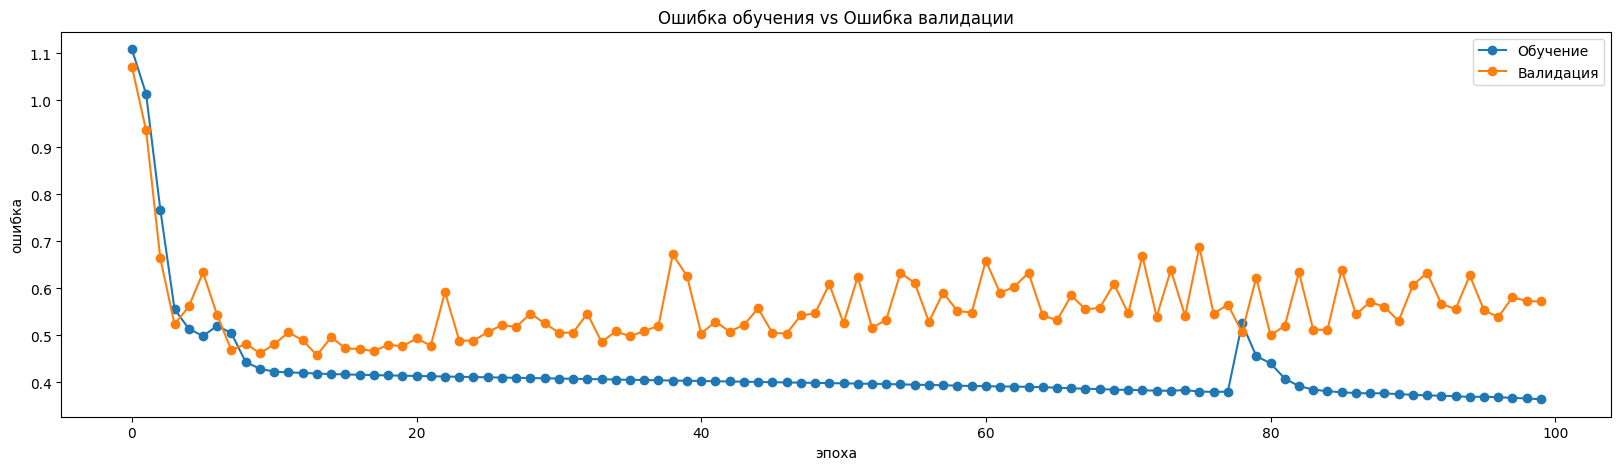

In [438]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_losses,'-o')
plt.plot(val_losses,'-o')
plt.xlabel('эпоха')
plt.ylabel('ошибка')
plt.legend(['Обучение','Валидация'])
plt.title('Ошибка обучения vs Ошибка валидации')
plt.show()

Анализ результатов:

* Полученный график говорит о том, что у модели присутствует недообучение. Сам факт того, что как тренировочная, так и валидационная ошибки уменьшаются, говорит о том, что модель хорошо обучается. После ~10 эпох появляется переобучение.

* Недообучение, скорее всего, свзяано с недостаточной информацией, которую несут признаки (стоило бы так же анализировать ходы шахматной партии). Такое решение я принял после того, как поэксперемнтировал с моделью: добавлял дропаут, изменял рамер пакета, упрощал и усложнял структуру нейросети. Все эти изменеия лишь меняли вид графика, однако он продолжал сходиться к ошибке 0.4.

* В дальнейшем, можно будет попробовать анализировать ходы шамматной партии. Например:
    * Разибвать ходы на их составляющие (фигура, клетка) и хранить первые 50-100 ходов по 3 признака на каждый ход (фигура, позиция клетки по горизонтали и вертикали). Учитывая, что фигуры являются текстовыми данными, можно сопоставить им числа таким образом, что более сильная фигура имеет большее число. Таким образом, модель, вероятно, сможет хорошо анализировать игру и улучшить свои результаты.

* Также я экспериментировал с балансировкой классов. На тепловой карте, приведенной далее видно, что модель плохо различает победу черных от победы белых и наоборот, чего нельзя сказать про ничью. Однако, даже небольшое увеличение баланса в сторону классов 0 и 1, отвечающих за победы, привело к значительному переобучению. Более того, я не смог предотвратить его даже с применением батч нормалиции, дропаутом, упрощением структуры модели и использованием weight_decay. Ни один из способов не избавил модель от переобучения. Возможно, это еще сильнее подтверждает мои выводы о том, что модели нужно больше признаков.

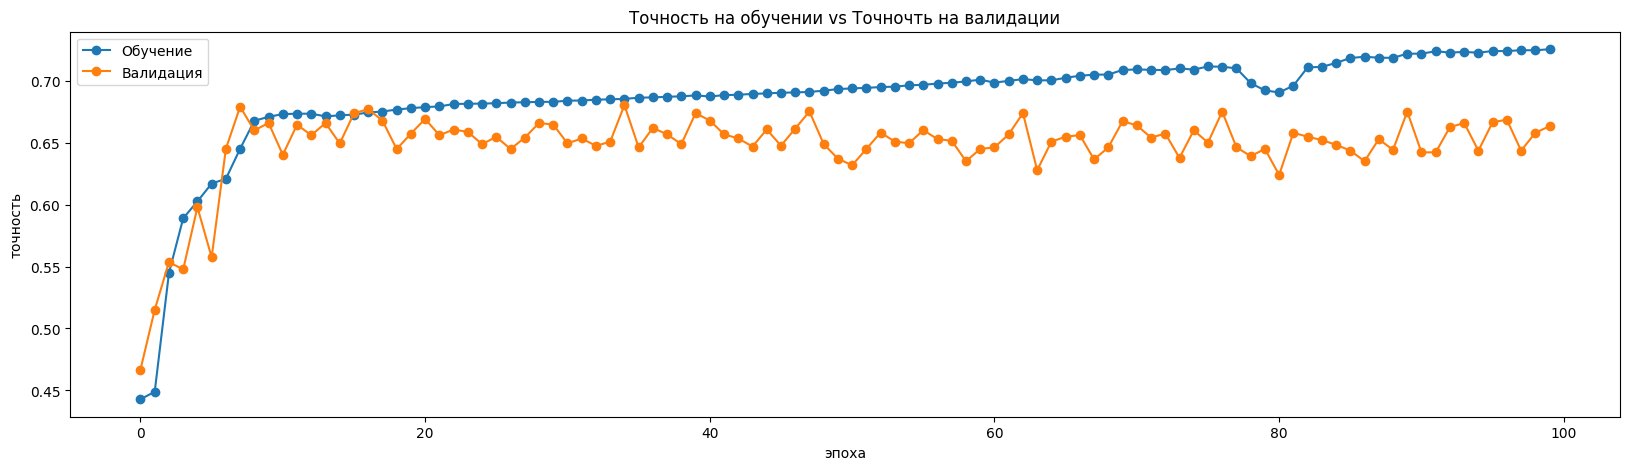

In [439]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_accs,'-o')
plt.plot(val_accs,'-o')
plt.xlabel('эпоха')
plt.ylabel('точность')
plt.legend(['Обучение','Валидация'])
plt.title('Точность на обучении vs Точночть на валидации')
plt.show()

In [440]:
model = torch.load('best-model.pt');
model.eval()

<ipython-input-440-1f419581dbab>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best-model.pt');


Classification_Model_FFNN(
  (fc1): Linear(in_features=18, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=3, bias=True)
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
)

In [441]:
preds=[]
trgts=[]
with torch.no_grad():
  for data in tqdm(test_loader):
    inputs, targets=data[0].to(device),data[1].to(device)
    outputs=model(inputs)
    targets=targets.to('cpu').numpy()
    pred = outputs.data.max(1, keepdim=True)[1]
    pred = pred.to('cpu').numpy()
    trgts.append(targets)
    preds.append(pred)

100%|██████████| 3/3 [00:00<00:00, 115.70it/s]


In [442]:
targets=[x for sub in trgts for x in sub]
predictions=[x[0] for sub in preds for x in sub]
targets=np.array(targets)
predictions=np.array(predictions)
predictions

array([0, 0, 2, ..., 0, 1, 0])

In [443]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

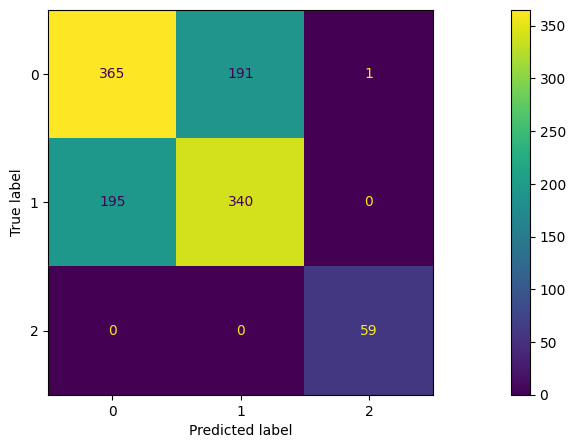

In [444]:
cm = confusion_matrix(targets, predictions)
ConfusionMatrixDisplay(cm).plot()

In [445]:
f1_score(targets, predictions,average='micro')

0.6637706342311034

Видно, что модель хорошо распознает ничью, но плохо распознает победителя. Причина, скорее всего, как я уже говорил, в недостаточной информации из признаков